In [1]:
import numpy as np
from pytisean import tiseanio
#from datasets import *
from matplotlib import pyplot as plt
from curvature import *
from subprocess import call
import pandas as pd
import os
from scipy.stats import gaussian_kde
from lorenz import get_lorenz
params = {'legend.fontsize': 12,
          'legend.handlelength': 2}
plt.rcParams.update(params)
import imp
import ensembles
imp.reload(ensembles)
from ensembles import generate_individual_ensembles_ordered_fixed, plot_d2, fit_slopes
from ensembles import generate_individual_ensembles_ordered_fixed
from scipy.stats import ks_2samp
from scipy.stats import wasserstein_distance as WD
from scipy.spatial.distance import jensenshannon as JS

import sys


## Step 1: Generate the Lorenz trajectory (refer to lorenz.py for more details), and use the X co-ordinate as the time-series to be used for DCE. 

In [2]:
P_power = 0
Q_power = 2
output_dir = 'lorenz_out/'

if not os.path.exists(output_dir):
    os.mkdir(output_dir)

n=100000
tmax=1000
ds_rate = 1
#n=100000
#timestep=0.05
noise_level = 0.0

[t,data] = get_lorenz(tmax=tmax,n=n, transient=0.1)
step_size=tmax/n

max_val  = np.zeros(3)
for i in range(3):
    max_val[i] = np.max((data[:,i])) - np.min((data[:,i]))

TS = data[:,0]

## Code for peak detection. To be used later when extracting modes and widths. 

In [3]:
def peak(x, c):
    return np.exp(-np.power(x - c, 2) / 16.0)

def lin_interp(x, y, i, half):
    return x[i] + (x[i+1] - x[i]) * ((half - y[i]) / (y[i+1] - y[i]))

def half_max_x(x, y):
    half = max(y)/2.0
    signs = np.sign(np.add(y, -half))
    zero_crossings = (signs[0:-2] != signs[1:-1])
    zero_crossings_i = np.where(zero_crossings)[0]

    if len(zero_crossings_i) == 1:
        return [lin_interp(x, y, zero_crossings_i[0], half),
                np.max(x)]
    
    return [lin_interp(x, y, zero_crossings_i[0], half),
            lin_interp(x, y, zero_crossings_i[1], half)]


## Step 2: Run d2 on the full dynamics trajectory and run the ensemble-based algorithm on the log-log correlation sum plot. 

## Generate histogram, PDFs of the slopes from the ensemble method, and estimate the mode/width of the distribution. 

Additional non-data files were created
Lower =  2.010157805855867 Upper =  2.1041529681404634 Mode =  2.0763711110403076
Error statistic =  0.02666503475749689
FWHM =  0.09399516228459648
Area within FWHM =  0.6772322918082063


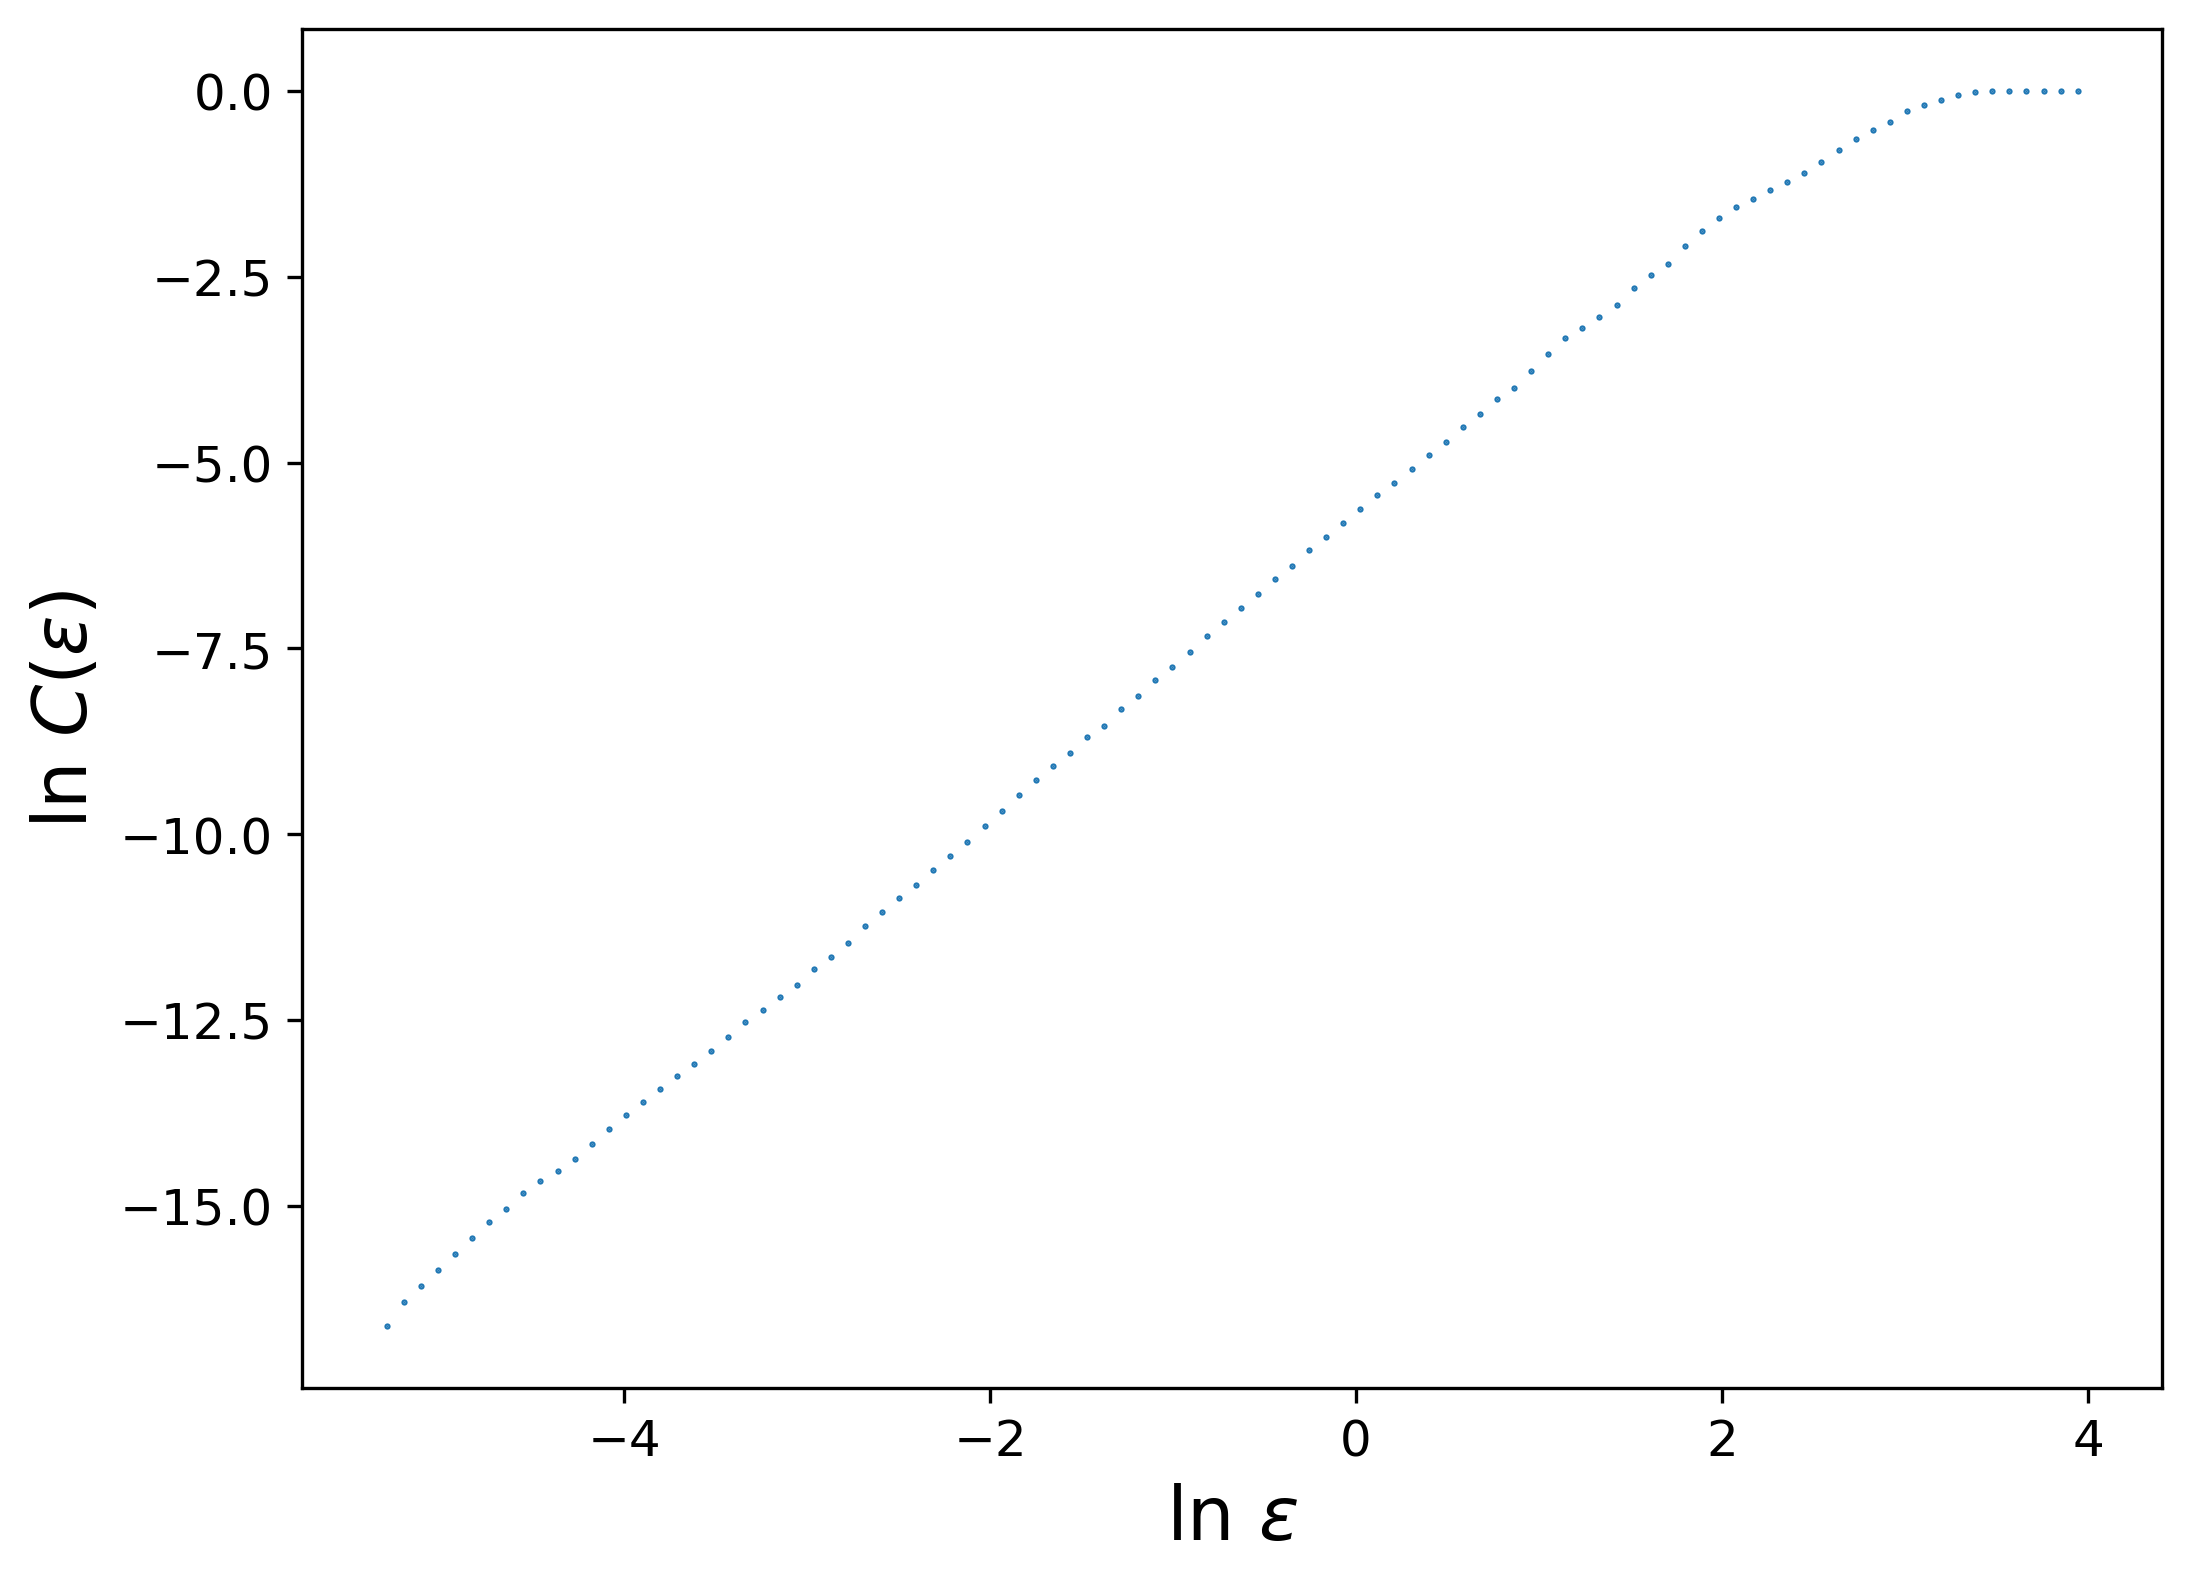

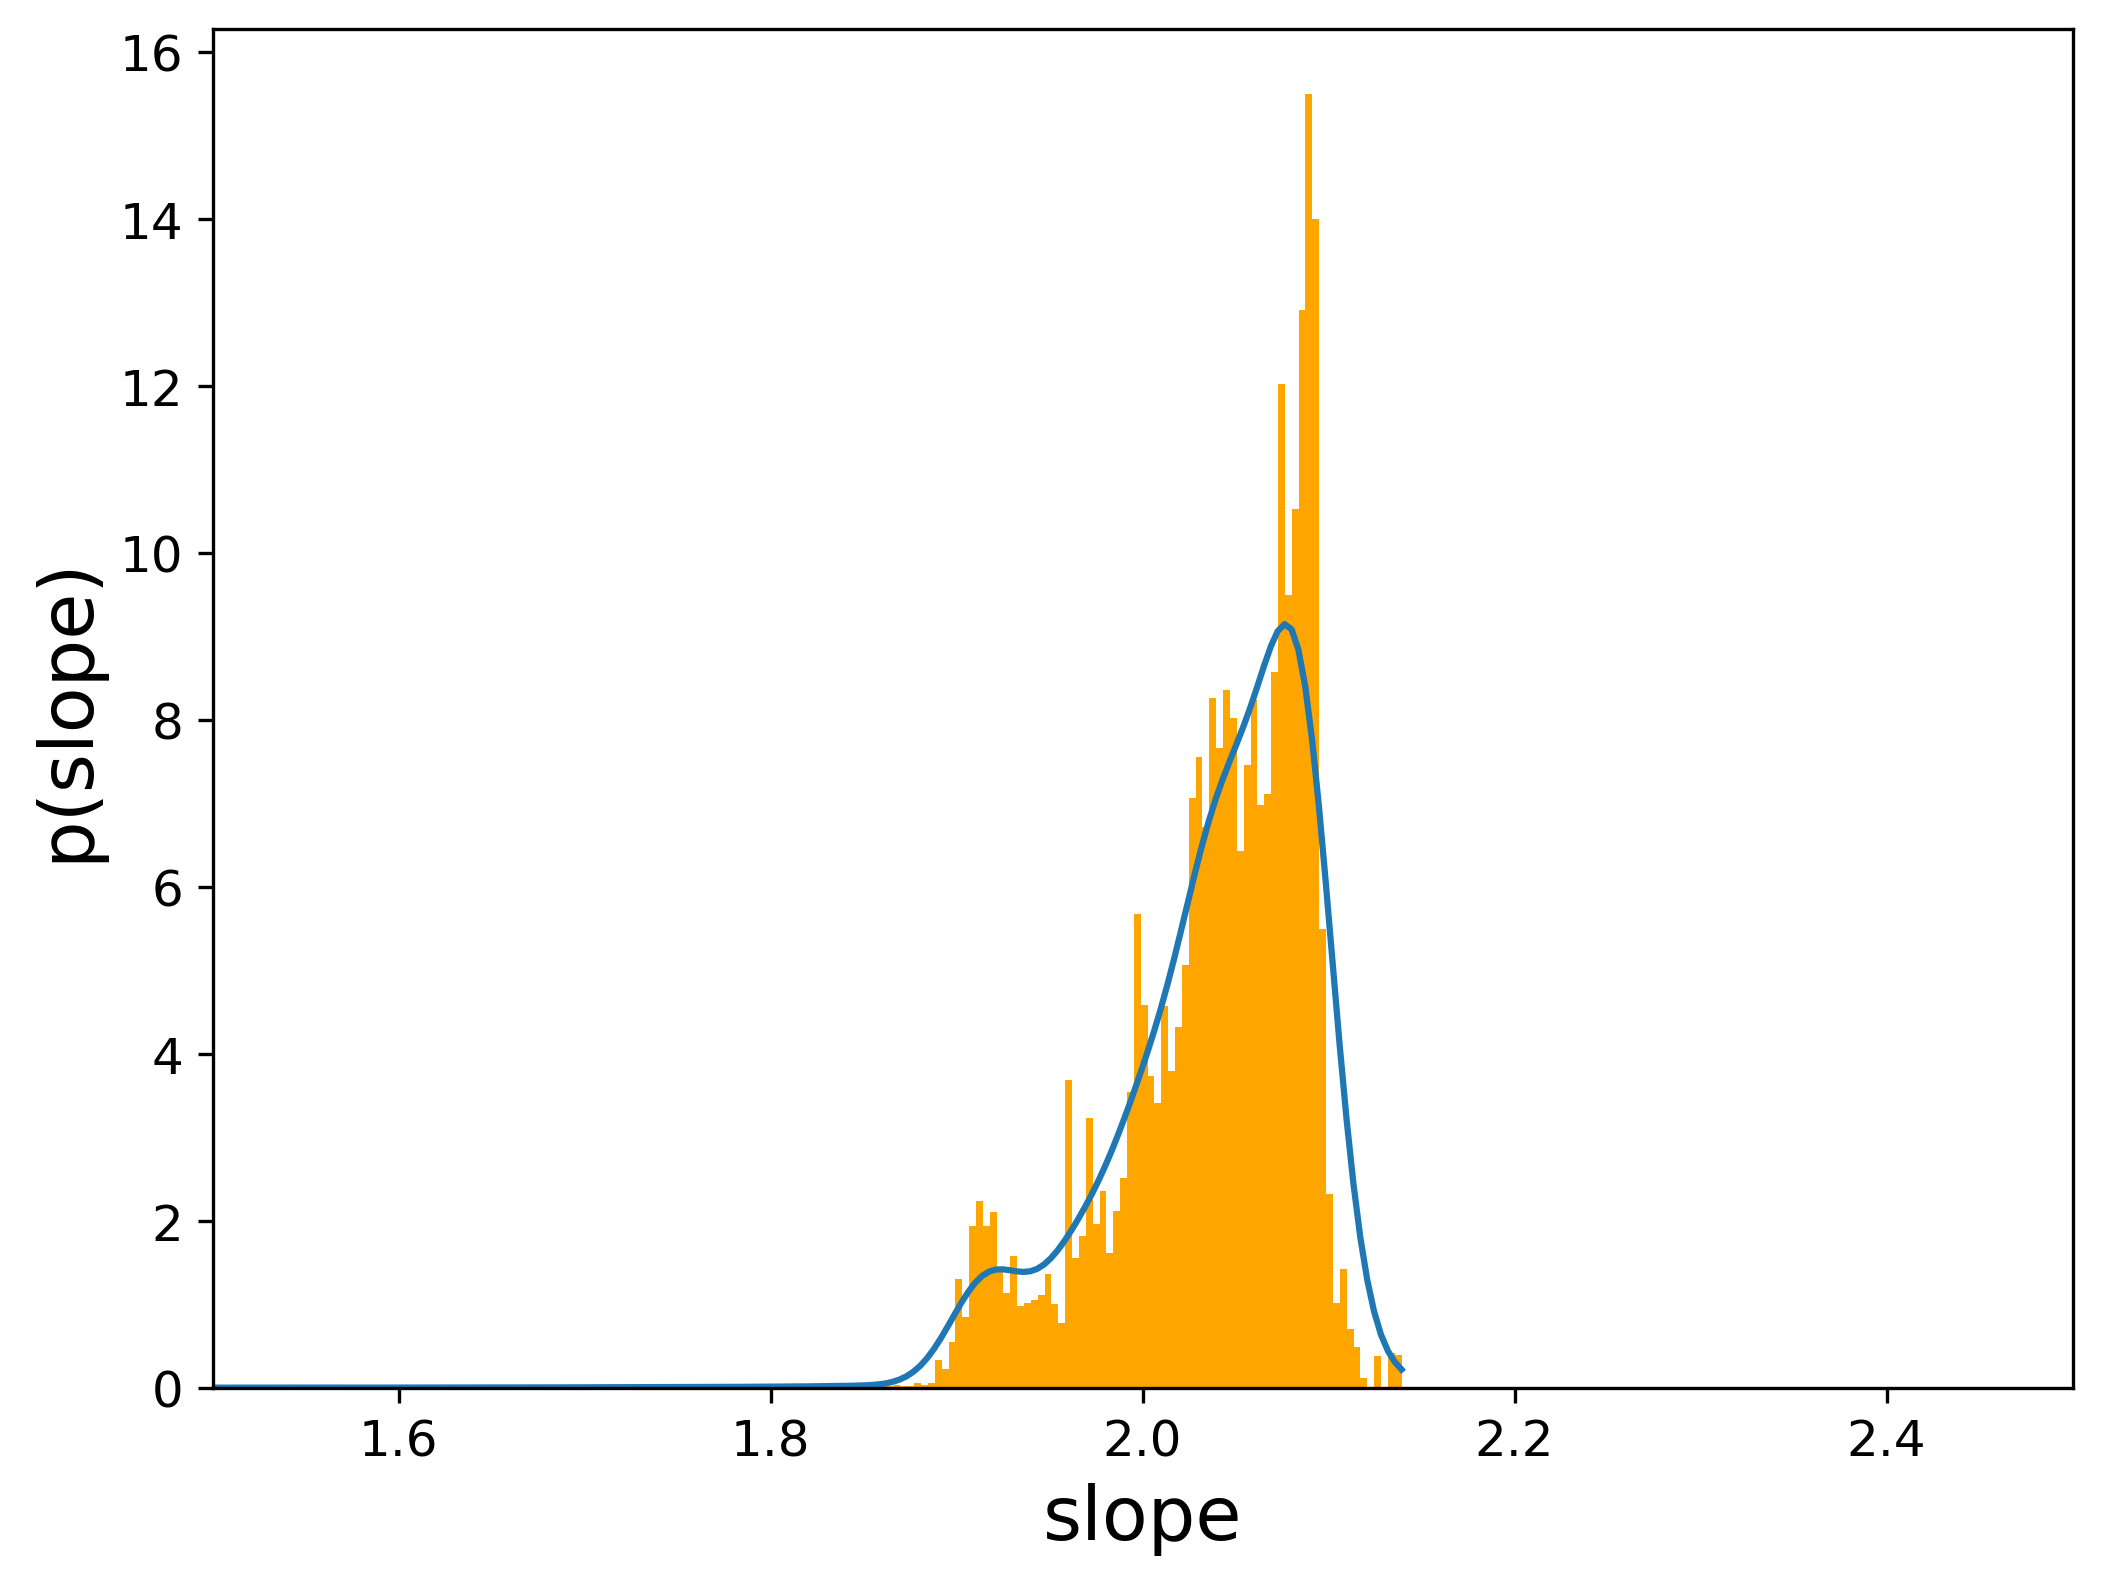

In [4]:
tiseanPath=''
dim_choice = 2 
data_per_dim = 100
th = 0
corr = tiseanio(tiseanPath + 'd2','-M','3,1','-c','1,2,3', '-t', th, '-r', 0.005, data=data, silent=True)

c2 = np.log(corr[0]['c2'])
region = c2[dim_choice*data_per_dim:(dim_choice+1)*data_per_dim,:]

plt.figure(figsize=(8,6), dpi=300)
plt.plot(region[:,0], region[:,1], '.', markersize=1)
plt.xlabel(r'ln $\epsilon$', fontsize=18)
plt.ylabel(r'ln $C(\epsilon)$', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(output_dir + '/lorenz_full_d2.png')

bounds = [region[-1,0], region[0,0]]
[lhs_arr, rhs_arr, slope, error, weights] = generate_individual_ensembles_ordered_fixed(region, bounds, lpower=1, epower=2)
kernel = gaussian_kde(slope, weights=weights)
positions = np.linspace(np.min(slope), np.max(slope), num=500)
plt.figure(figsize=(8,6), dpi=300)
p = plt.plot(positions, kernel(positions))
color = p[0].get_color()

arr = plt.hist(slope, weights=weights, bins=500, color='orange', density=True)
plt.xlabel(r'slope', fontsize=18)
plt.ylabel(r'p(slope)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(1.5,2.5)
plt.savefig(output_dir + '/lorenz_full_pdf.png')

positions_save = positions
lower_x, upper_x = half_max_x(positions,kernel(positions))
mode = positions[np.argmax(kernel(positions))]

print("Lower = ", lower_x, "Upper = ", upper_x, "Mode = ", mode)
fwhm = positions[np.where(np.logical_and(positions <= upper_x, positions >= lower_x))]

print("Error statistic = ", np.std(positions[np.where(np.logical_and(positions <= upper_x, positions >= lower_x))]))
print("FWHM = ", upper_x - lower_x)
print("Area within FWHM = ", np.sum(kernel(fwhm)) / np.sum(kernel(positions)))

positions = positions_save

## Step 3: Get the LHS and RHS marker distributions. These tell us where we expect the LHS and RHS of the scaling region is expected to lie.

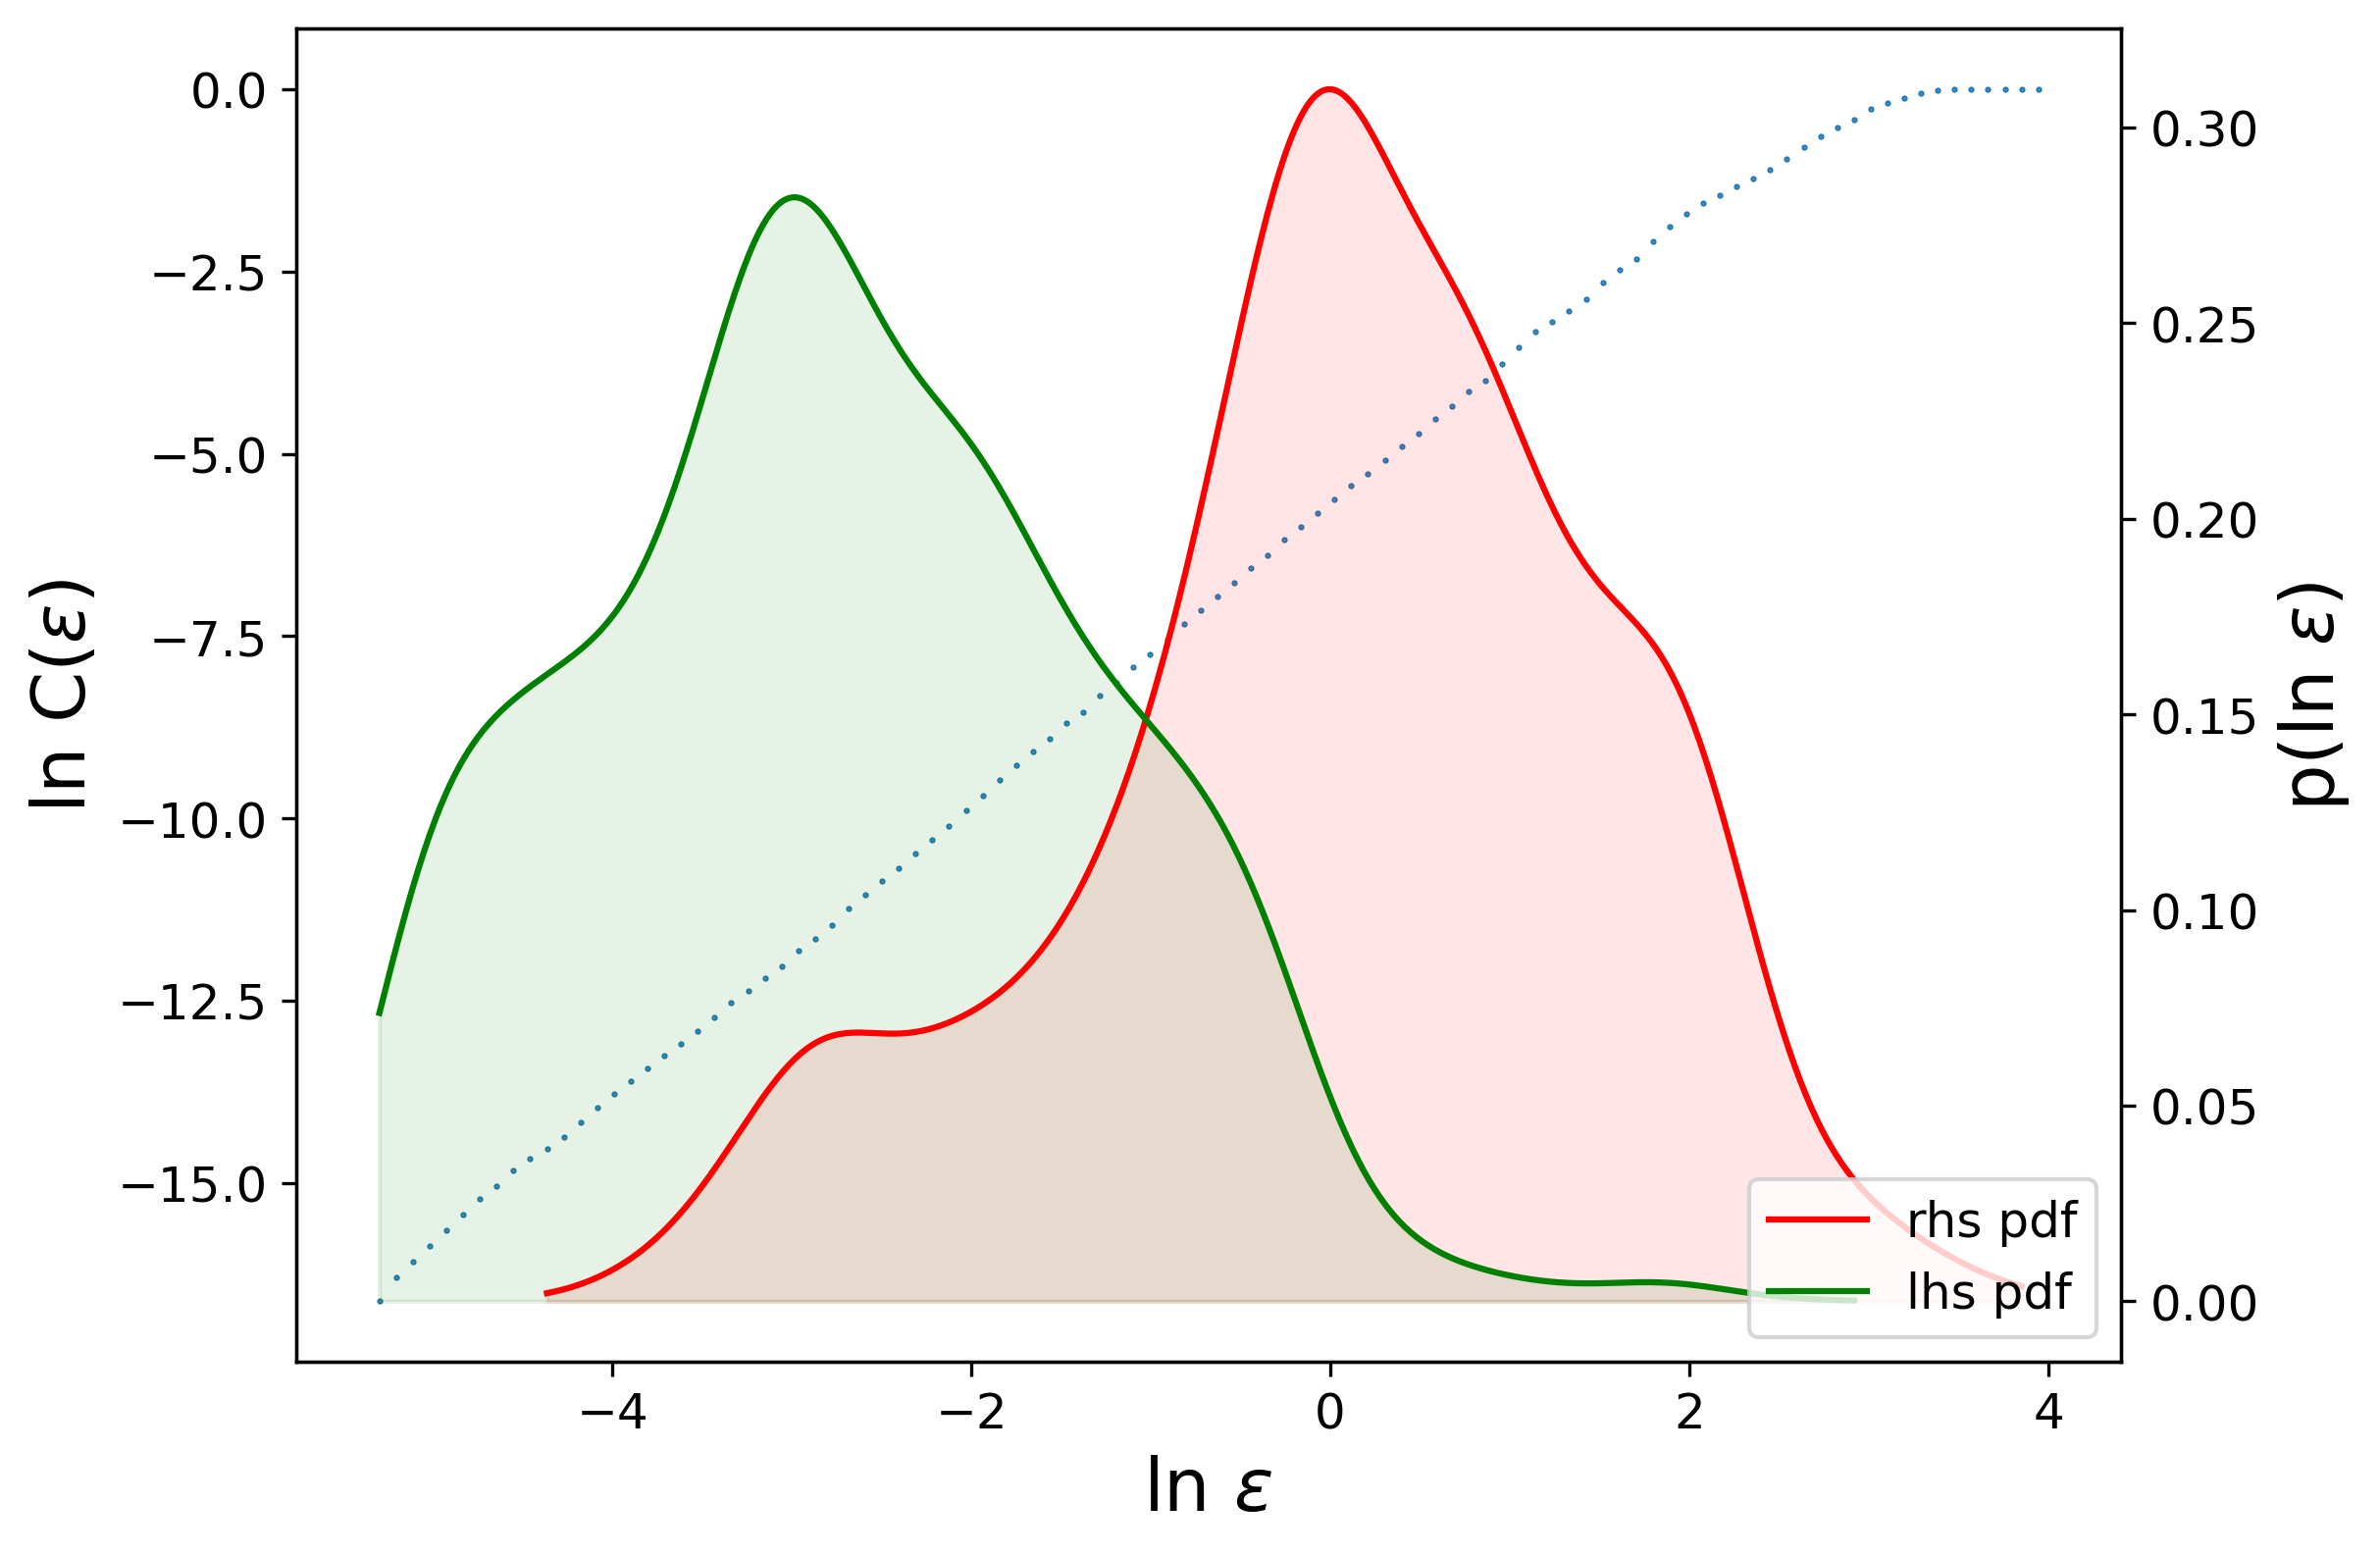

In [5]:
lhs_arr_save = lhs_arr
rhs_arr_save = rhs_arr

estimate = np.argmax(kernel(positions))
#idx = np.where(np.abs(slope - positions[estimate]) < 2000)[0]

plt.figure(figsize=(8,6),dpi=300)
ax1 = plt.gca()
ax1.plot(region[:,0], region[:,1], '.', markersize=1)
ax1.set_ylabel(r'ln C($\epsilon$)', fontsize=18)
ax2 = ax1.twinx()
ax2.set_ylabel(r'p(ln $\epsilon$)', fontsize=18)
ax1.tick_params(axis="x", labelsize=12)
ax1.tick_params(axis="y", labelsize=12)
ax2.tick_params(axis="y", labelsize=12)
rhs_array = region[lhs_arr,0]
kernel = gaussian_kde(rhs_array, weights=weights)
positions = np.linspace(np.min(rhs_array), np.max(rhs_array), num=500)
p = ax2.plot(positions, kernel(positions), color='red', label='rhs pdf')
ax2.fill_between(positions, kernel(positions), color='red', alpha=.1)
lhs_array = region[rhs_arr,0]
kernel = gaussian_kde(lhs_array, weights=weights)
positions = np.linspace(np.min(lhs_array), np.max(lhs_array), num=500)
p = ax2.plot(positions, kernel(positions), color='green', label='lhs pdf')
ax2.fill_between(positions, kernel(positions), color='green', alpha=.1)
ax1.set_xlabel(r'ln $\epsilon$ ', fontsize=18) 
ax2.legend(loc='lower right')
plt.savefig(output_dir + "/lorenz_full_bounds.png")
lhs_arr = lhs_arr_save
rhs_arr = rhs_arr_save

## Step 4: Generate a 2D representation of the slope distribution for debugging. 
### Each point on this plot corresponds to a fit with LHS = x-coordinate and RHS = y-coordinate. 
### The size of the marker is inversely proportional to the fit error (or directly proportional to the fit quality)
### The color of the marker represents the slope of the fit. 

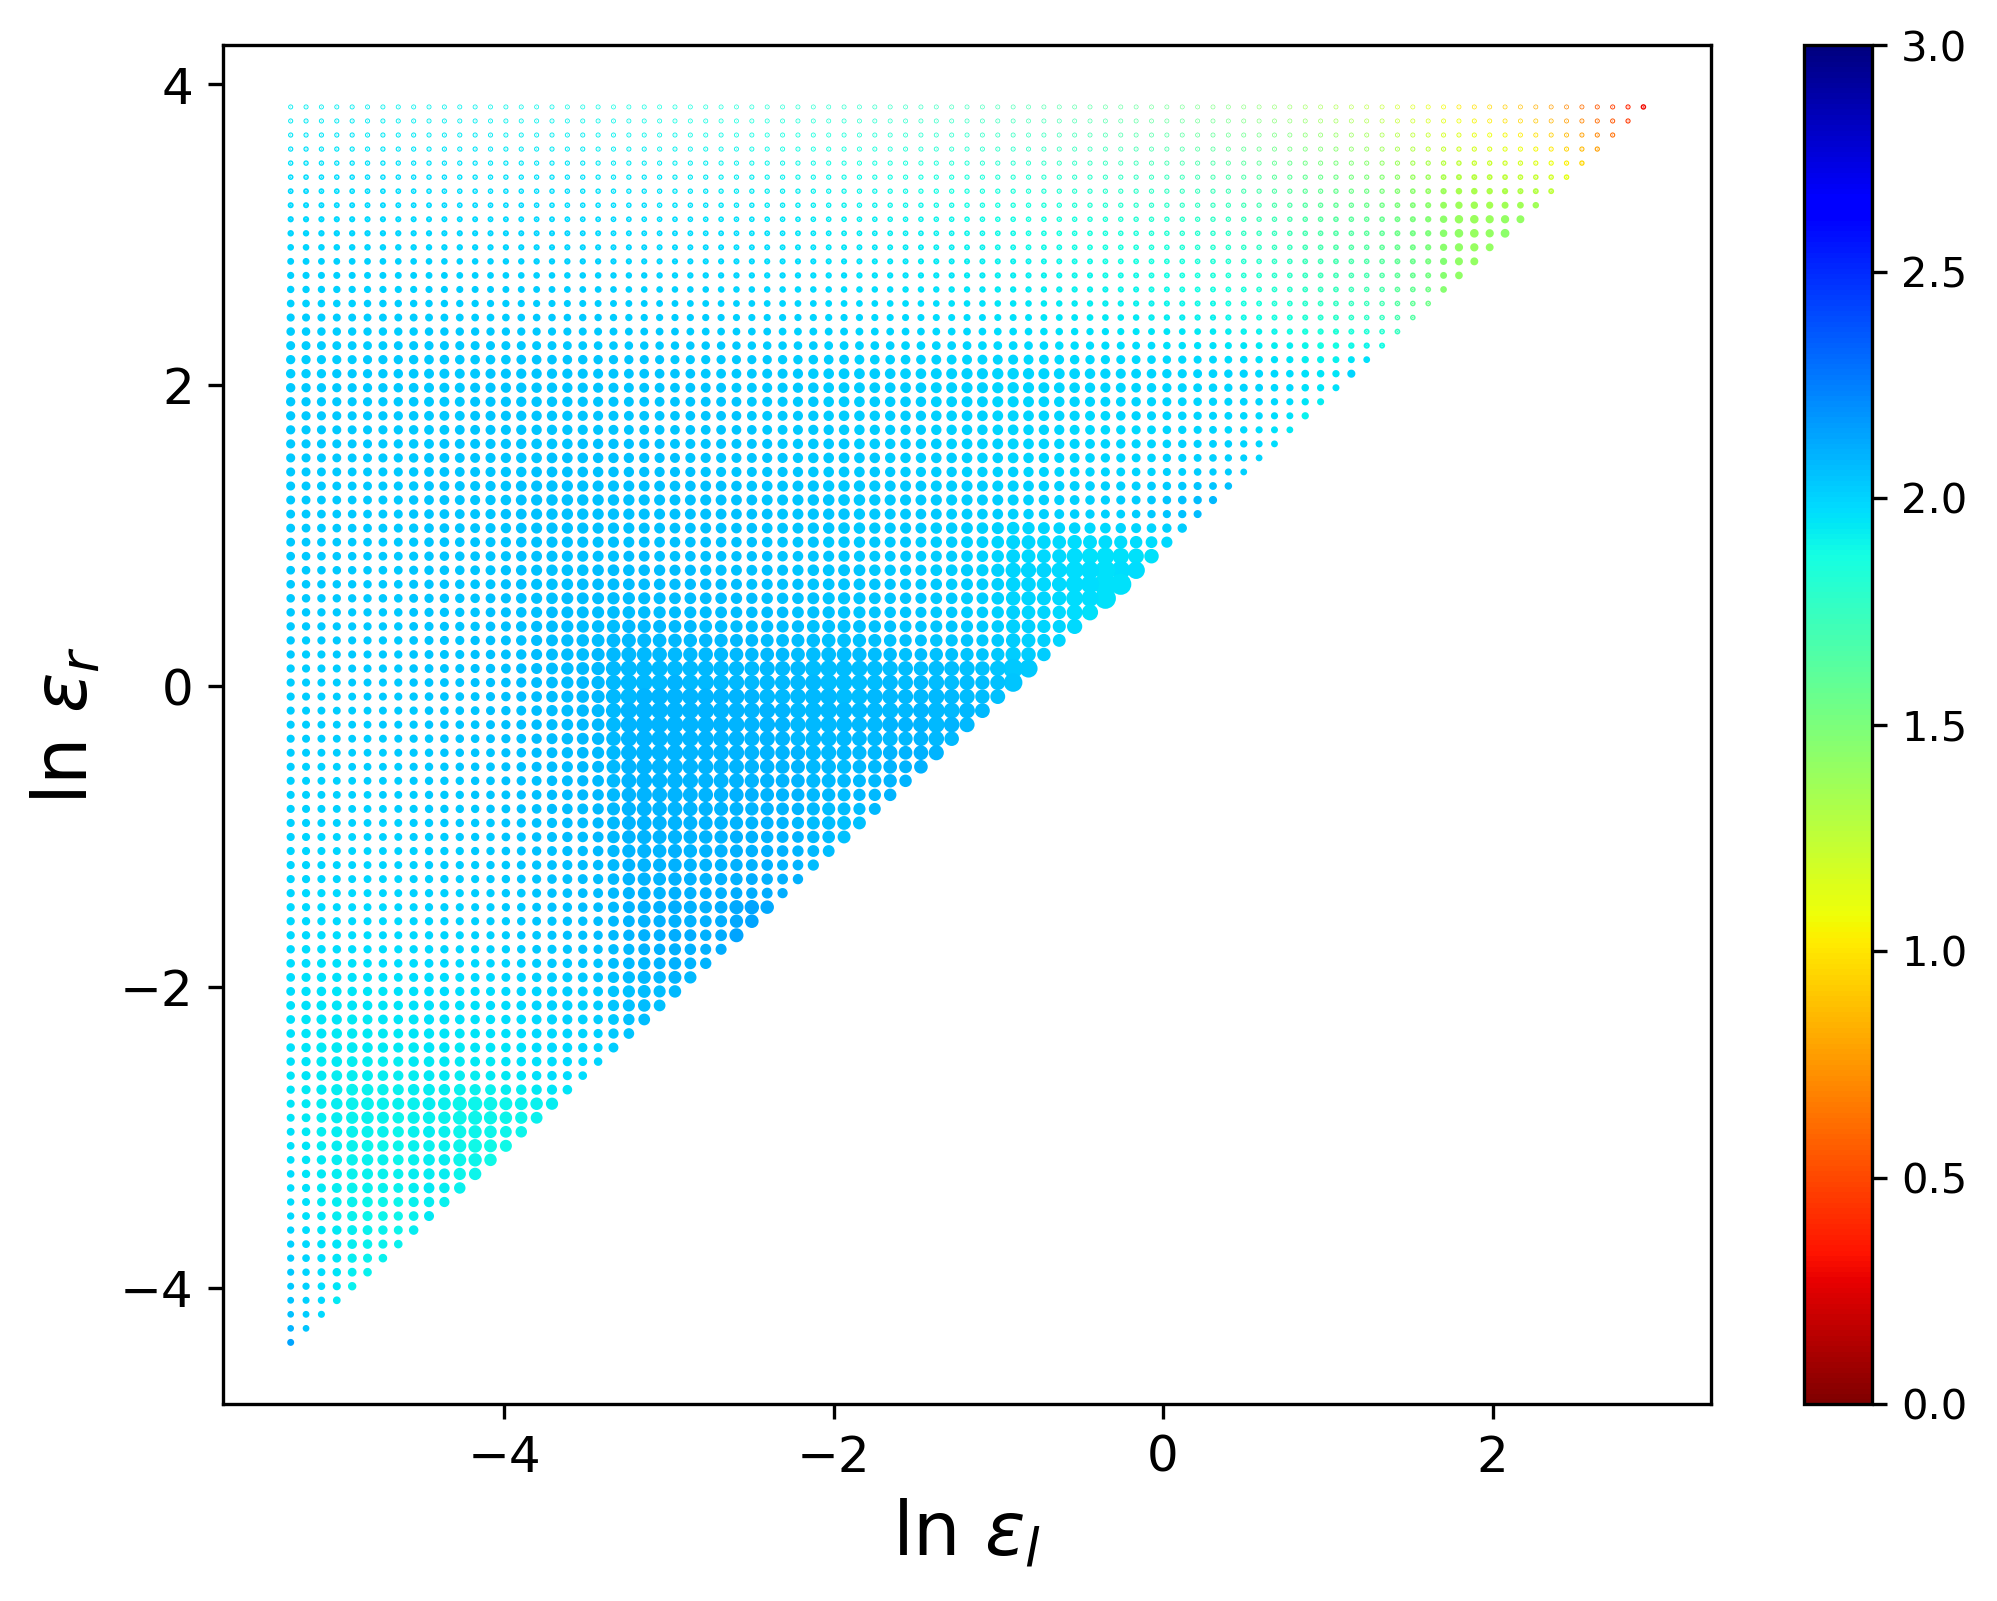

In [6]:
plt.figure(figsize=(8,6), dpi=300)
plt.scatter(region[rhs_arr,0], region[lhs_arr,0], s=20*(weights/np.max(weights)), c = slope, cmap=plt.cm.jet_r)#, '.', c = weights[idx], markersize=1)
plt.xlabel('ln $\epsilon_l$', fontsize=18)
plt.ylabel('ln $\epsilon_r$', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar()
plt.clim([0,3])
plt.savefig(output_dir + '/lorenz_full_2d_pdf.png')

## Step 5: Run d2 on the reconstruction of the time-series for different embedding dimensions. Chose a suitable tau, number of dimensions to embed in, and other hyperparameters for the d2 algorithm.
 
## For each correlation sum plot generated for each embedding dimension (m), 
### 1. Run the ensemble algorithm.
### 2. Compare the distribution with the distribution of dimension m-1 using Wasserstein distance.
### 3. If the Wasserstein distance is below a threshold, we find that distributions are converging, indicating a sufficient dimension for embedding. 
 

Additional non-data files were created


<ipython-input-7-866d64e88e6e>:8: RuntimeWarning: divide by zero encountered in log
  c2 = np.log(corr[0]['c2'])


mode= 0.9995391520978493 FWHM= 0.004150041904268598 prob= 0.7954530127375956 error= 0.0012583834840336984
mode= 1.8876448344648735 FWHM= 0.04433724734063427 prob= 0.696715209300966 error= 0.013177285345360537
mode= 2.0627223937241554 FWHM= 0.08868540054305152 prob= 0.6799916850643231 error= 0.026026717393584253
mode= 2.0715381629617307 FWHM= 0.062453874621195116 prob= 0.6145827061149362 error= 0.017364099580788394
mode= 2.0636071490883454 FWHM= 0.036619100225385726 prob= 0.5676252179398923 error= 0.010703696354940895
mode= 2.038484335808845 FWHM= 0.044791170499145494 prob= 0.608974089385521 error= 0.012197267904457057
mode= 2.04353091715127 FWHM= 0.030522310885242376 prob= 0.575484451755938 error= 0.007718457883120749
mode= 2.060476277057827 FWHM= 0.061233192527835545 prob= 0.7340777541213162 error= 0.018380293777857337
mode= 2.0735025445105673 FWHM= 0.050678716480648145 prob= 0.6123782438305851 error= 0.013905618195610567
mode= 2.0847828649820728 FWHM= 0.031756695885519104 prob= 0.648

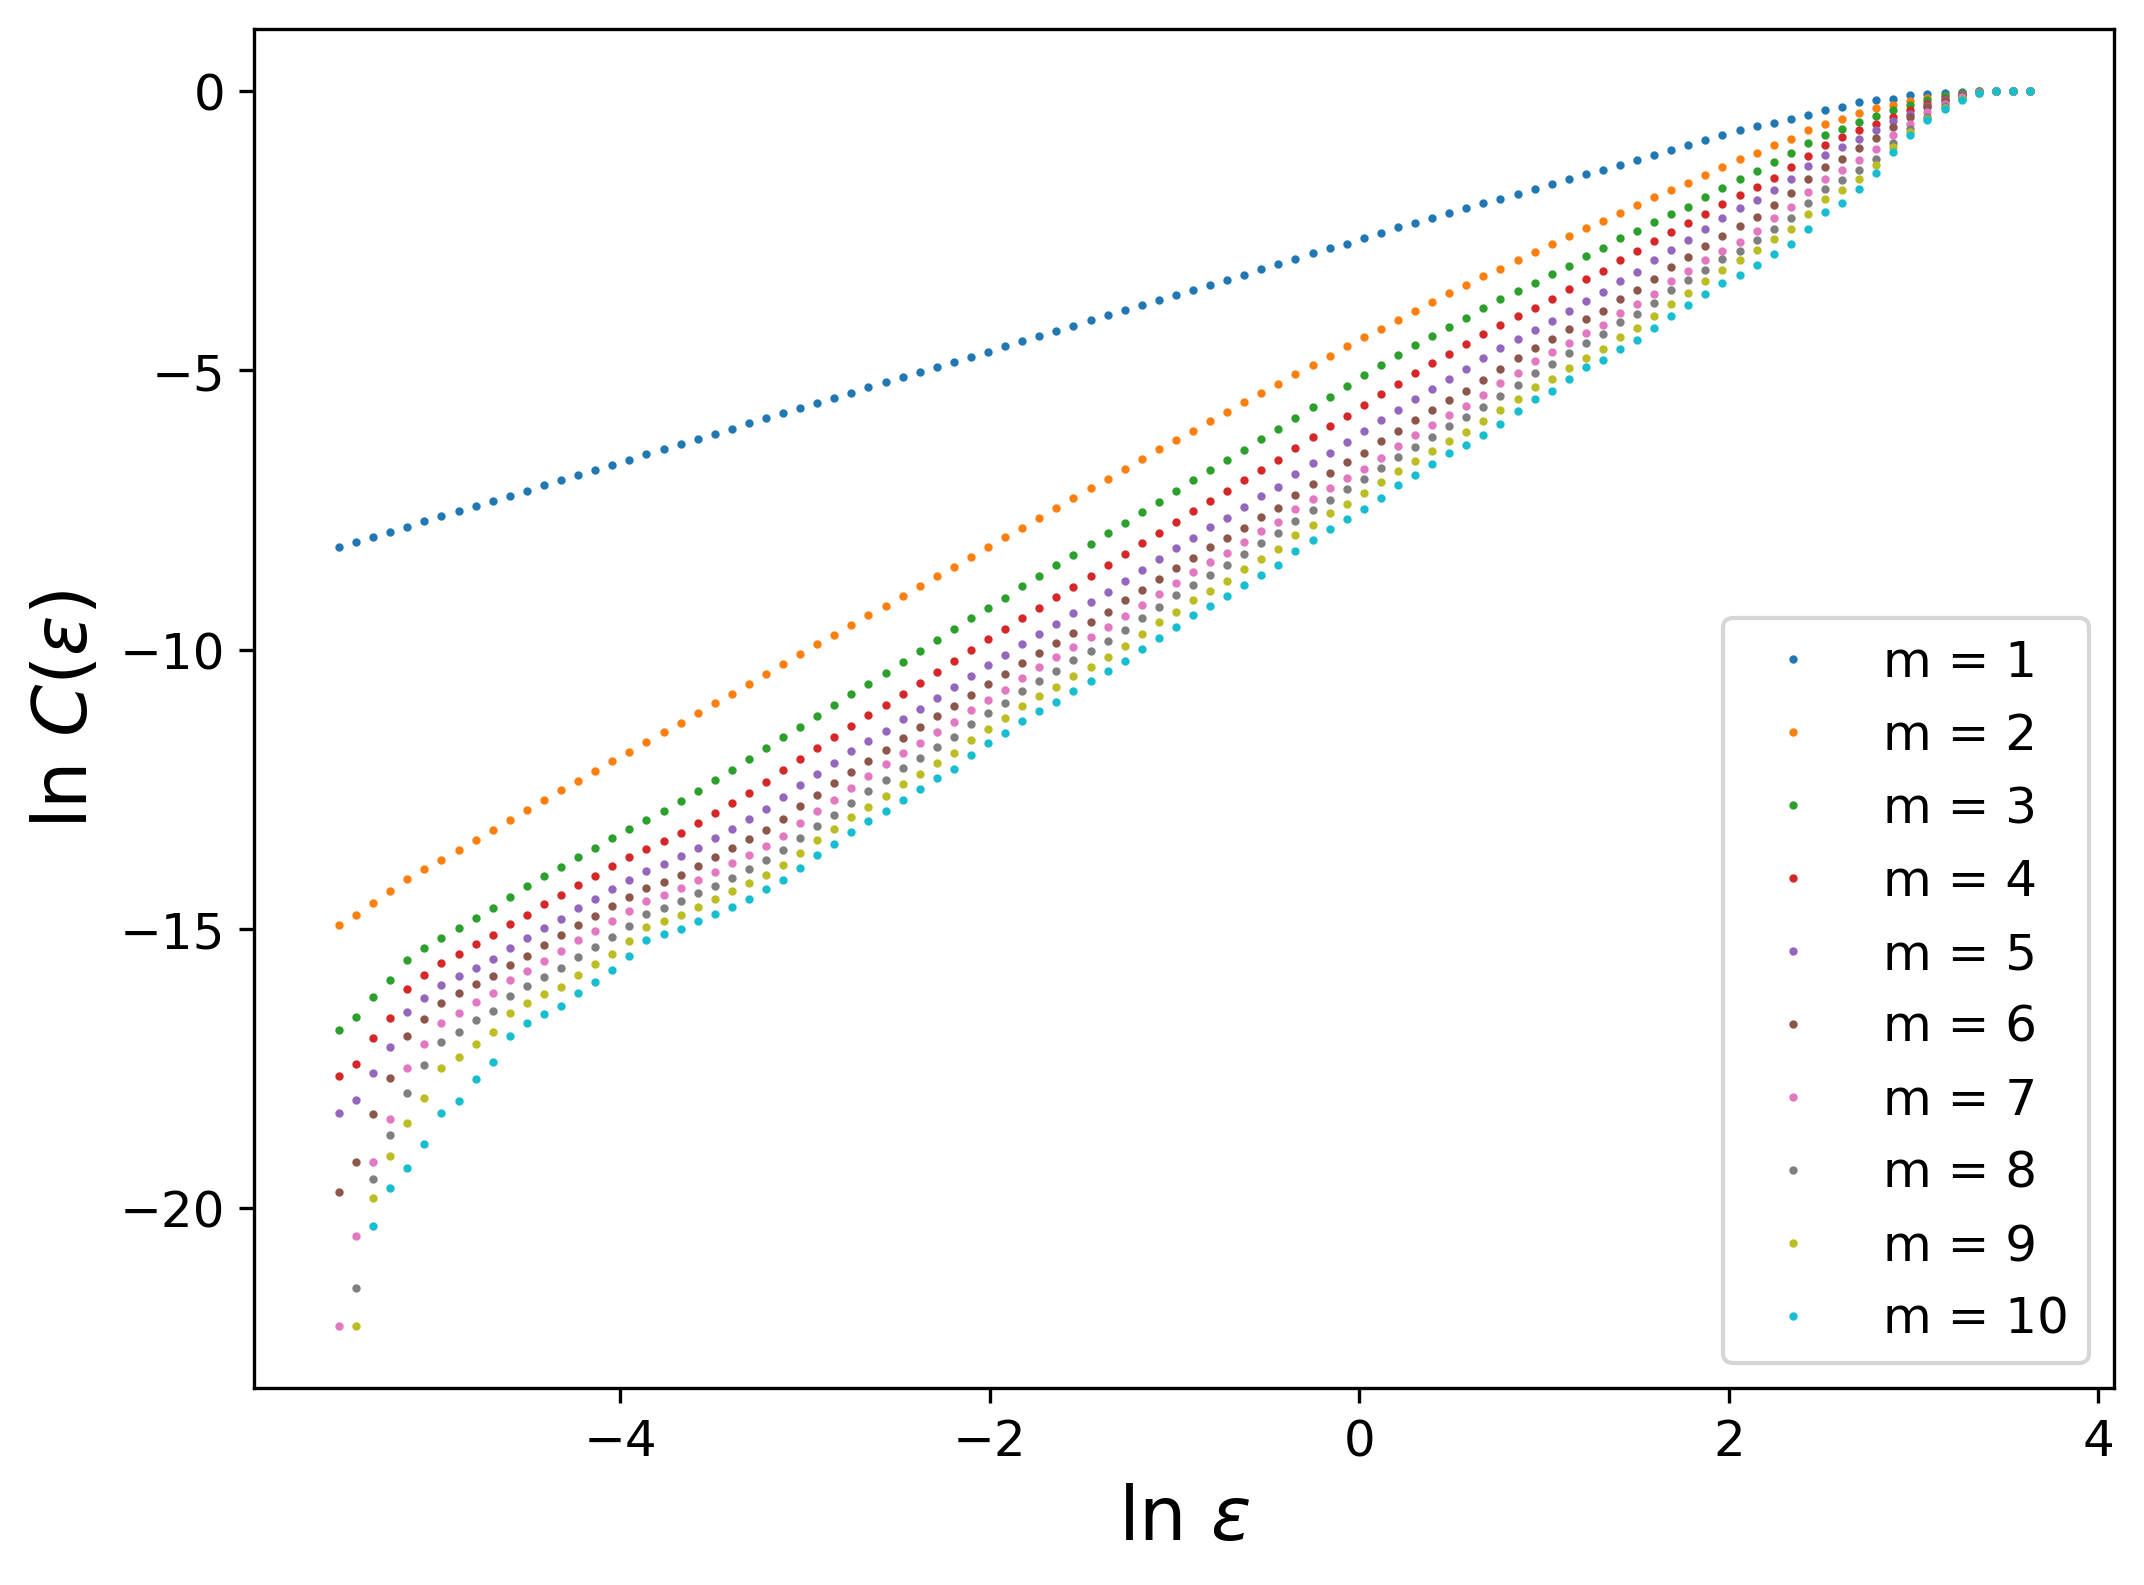

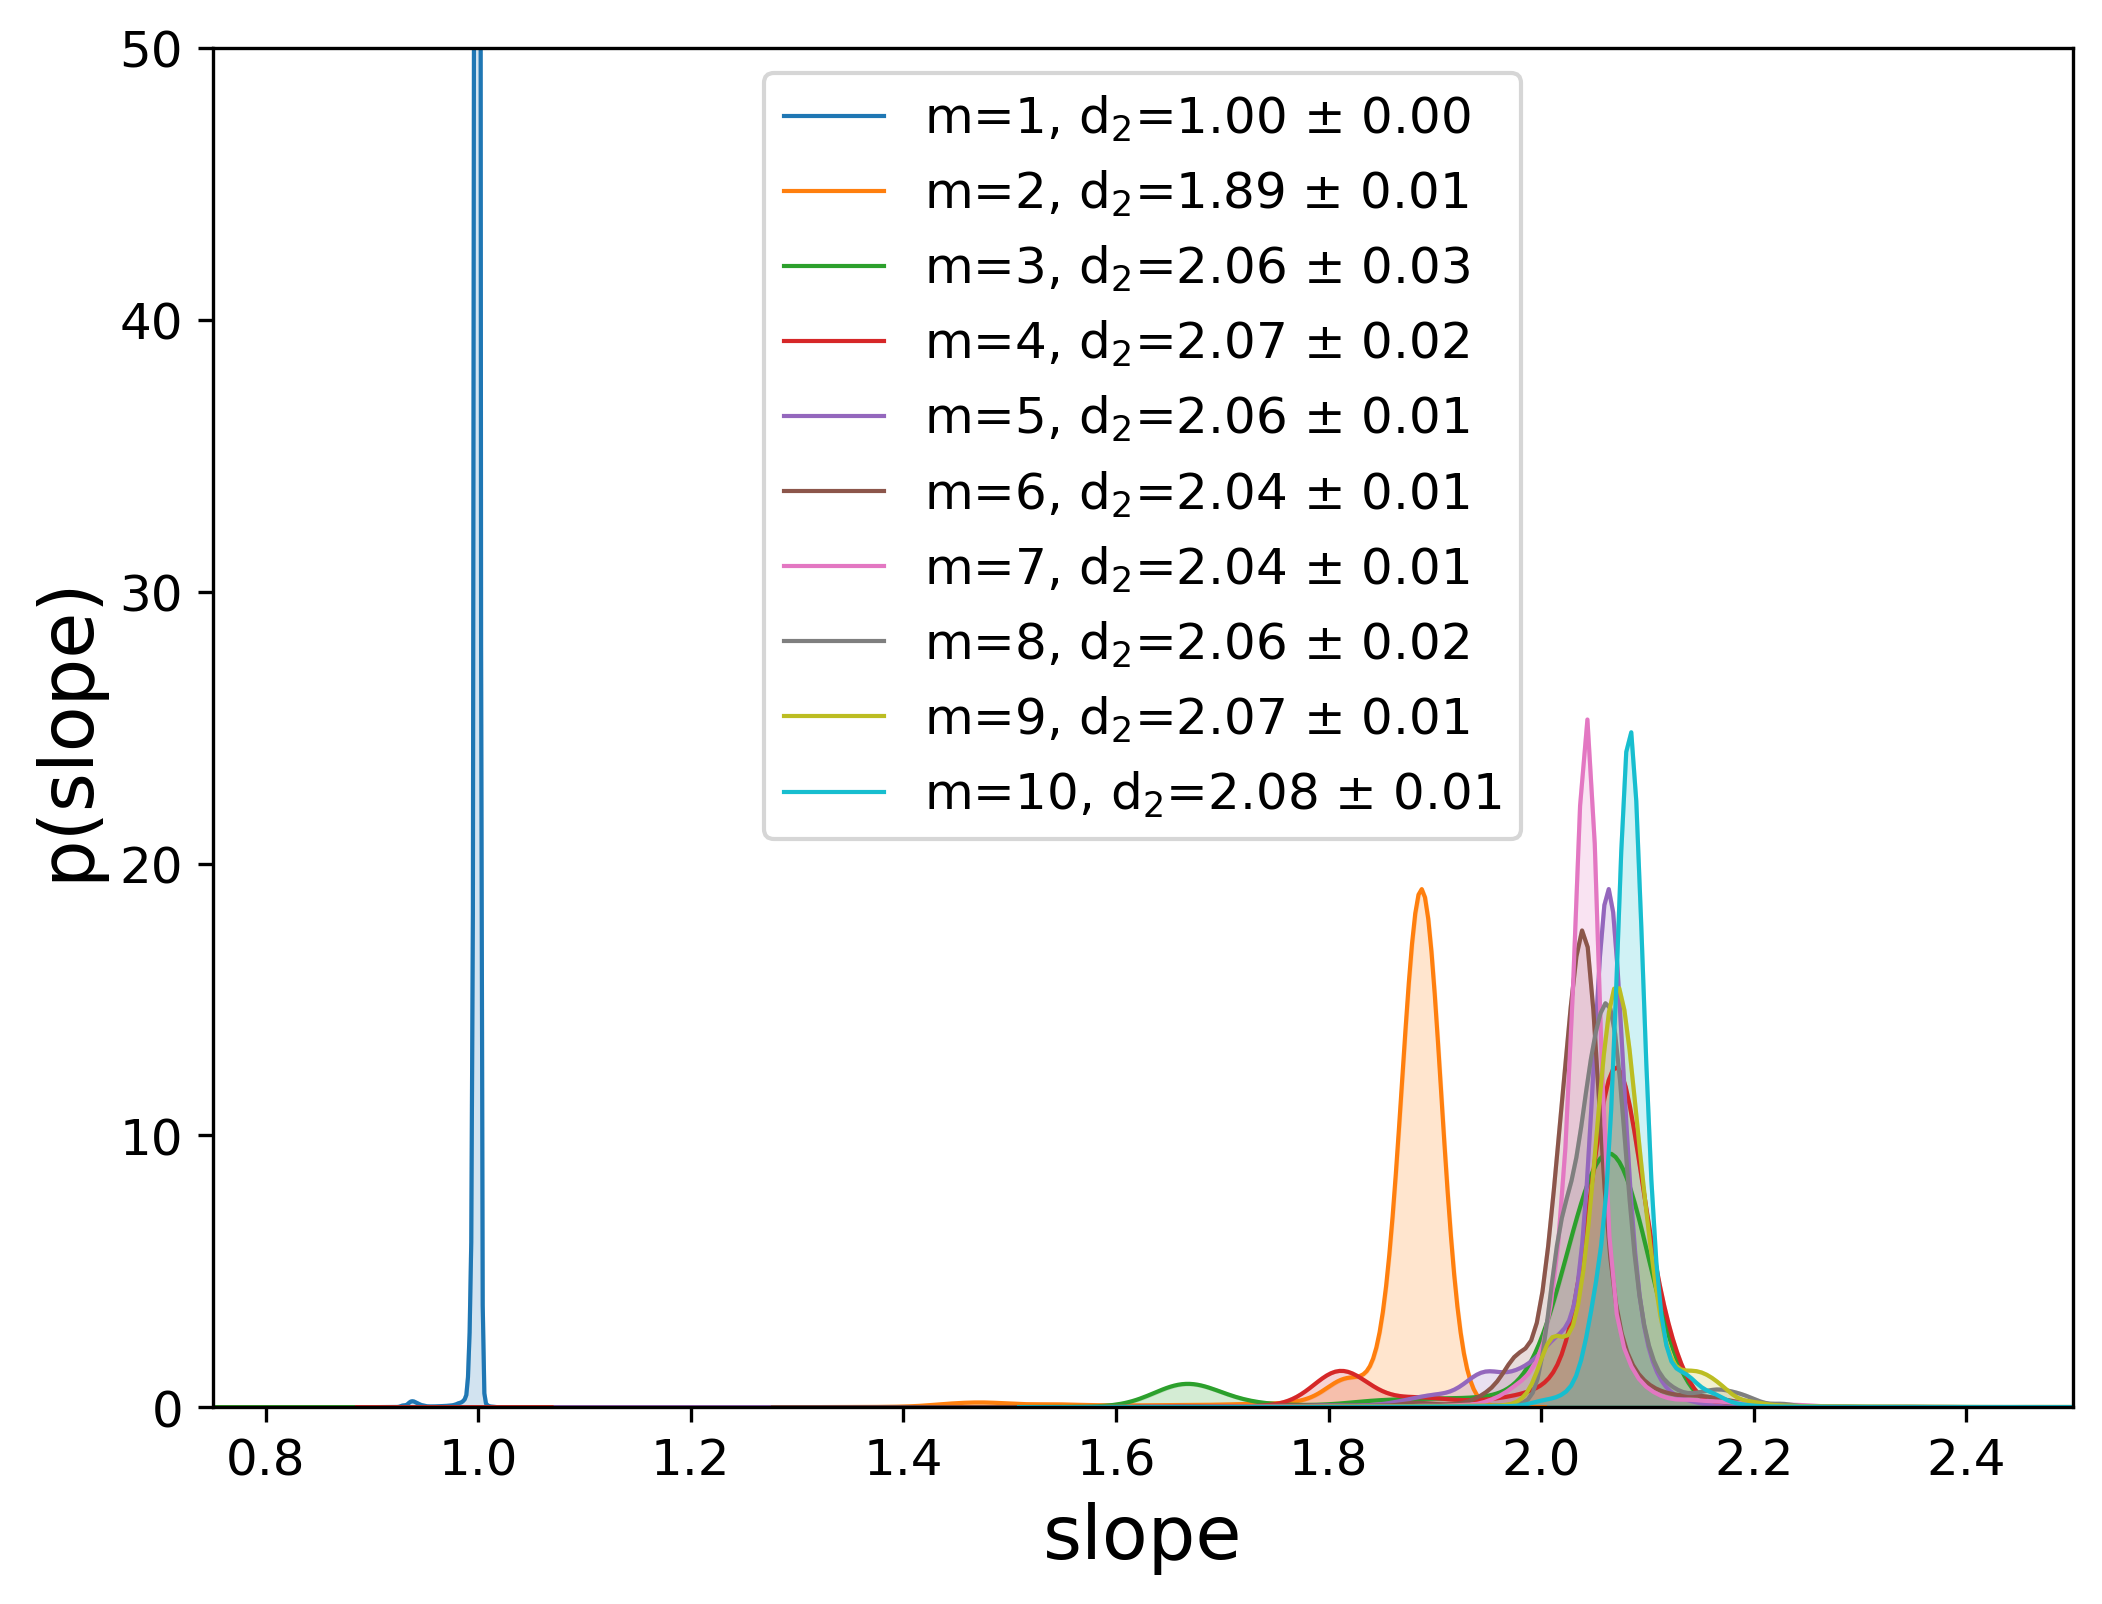

In [7]:
tau = 18
dim_choice = 6
dims = 10
data_per_dim = 100
#th = get_theiler_reconstruction(data, dim_choice, data_per_dim, dims, tau)
th=0
corr = tiseanio('d2','-d',tau,'-M','1,{}'.format(dims),'-t', th, '-r', 0.004, data=TS, silent=True)
c2 = np.log(corr[0]['c2'])

plt.figure(figsize=(8,6), dpi=300)
dim_range = np.arange(0,dims)

for dim_choice in dim_range:
    region = c2[dim_choice*data_per_dim:(dim_choice+1)*data_per_dim,:]
    plt.plot(region[:,0], region[:,1], '.', ms=2, label='m = {}'.format(dim_choice+1))

plt.xlabel(r'ln $\epsilon$', fontsize=18)
plt.ylabel(r'ln $C(\epsilon)$', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 12})
plt.savefig(output_dir + '/lorenz_reconstruction_{}_d2.png'.format(tau))
    
plt.figure(figsize=(8,6), dpi=300)

KS_vals = []
th_vals = []
first_slope = True

for dim_choice in dim_range:
    region = c2[dim_choice*data_per_dim:(dim_choice+1)*data_per_dim,:]
    region = (region[~np.isinf(region[:,1])])
    bounds = [region[-1,0], region[0,0]]
    [lhs_arr, rhs_arr, slope, error, weights] = generate_individual_ensembles_ordered_fixed(region, bounds, 1, 2)
    kernel = gaussian_kde(slope, weights=weights)
    positions = np.linspace(np.min(slope), np.max(slope), num=500)
    lower_x, upper_x = half_max_x(positions,kernel(positions))
    mode = positions[np.argmax(kernel(positions))]
    fwhm = positions[np.where(np.logical_and(positions <= upper_x, positions >= lower_x))]
    error = np.std(positions[np.where(np.logical_and(positions <= upper_x, positions >= lower_x))])
    print("mode=", mode, "FWHM=",upper_x-lower_x, "prob=", np.sum(kernel(fwhm)) / np.sum(kernel(positions)), "error=",error)

    p = plt.plot(positions, kernel(positions), label=r'm=%d, d$_2$=%.2f $\pm$ %.2f' % (dim_choice+1, 
                                                                             positions[np.argmax(kernel(positions))],error), lw=1)
    color = p[0].get_color()
    plt.fill_between(positions, kernel(positions), color=color, alpha=.2)
    slope_samples = slope
    
    if not first_slope:
        #KS = ks_2samp(slope_samples, slope_prev)[0]
        WD_res = WD(slope_samples, slope_prev, weights, weights_prev)
        KS_vals.append(WD_res)
        
    slope_prev = slope_samples
    weights_prev = weights
    first_slope = False

plt.xlabel(r'slope', fontsize=18)
plt.ylabel(r'p(slope)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim((0.75,2.5))
plt.ylim((0,50))
#plt.title(r"$\tau = %d$ d$_2$ = %.2f" % (tau , positions[np.argmax(kernel(positions))]))
plt.legend(prop={'size': 12})
plt.savefig(output_dir + '/lorenz_reconstruction_{}_pdf.png'.format(tau))

print(KS_vals)

## Plot the Wasserstein profile. We assign a threshold of 0.1 for convergence. We see a convergence at m = 4 for this example.

[0.8721177571499914, 0.16169341661076375, 0.020179433822986488, 0.022514414409390206, 0.02105160854212344, 0.009643860217188643, 0.017310543486958544, 0.015991917451867052, 0.015108960059460812]


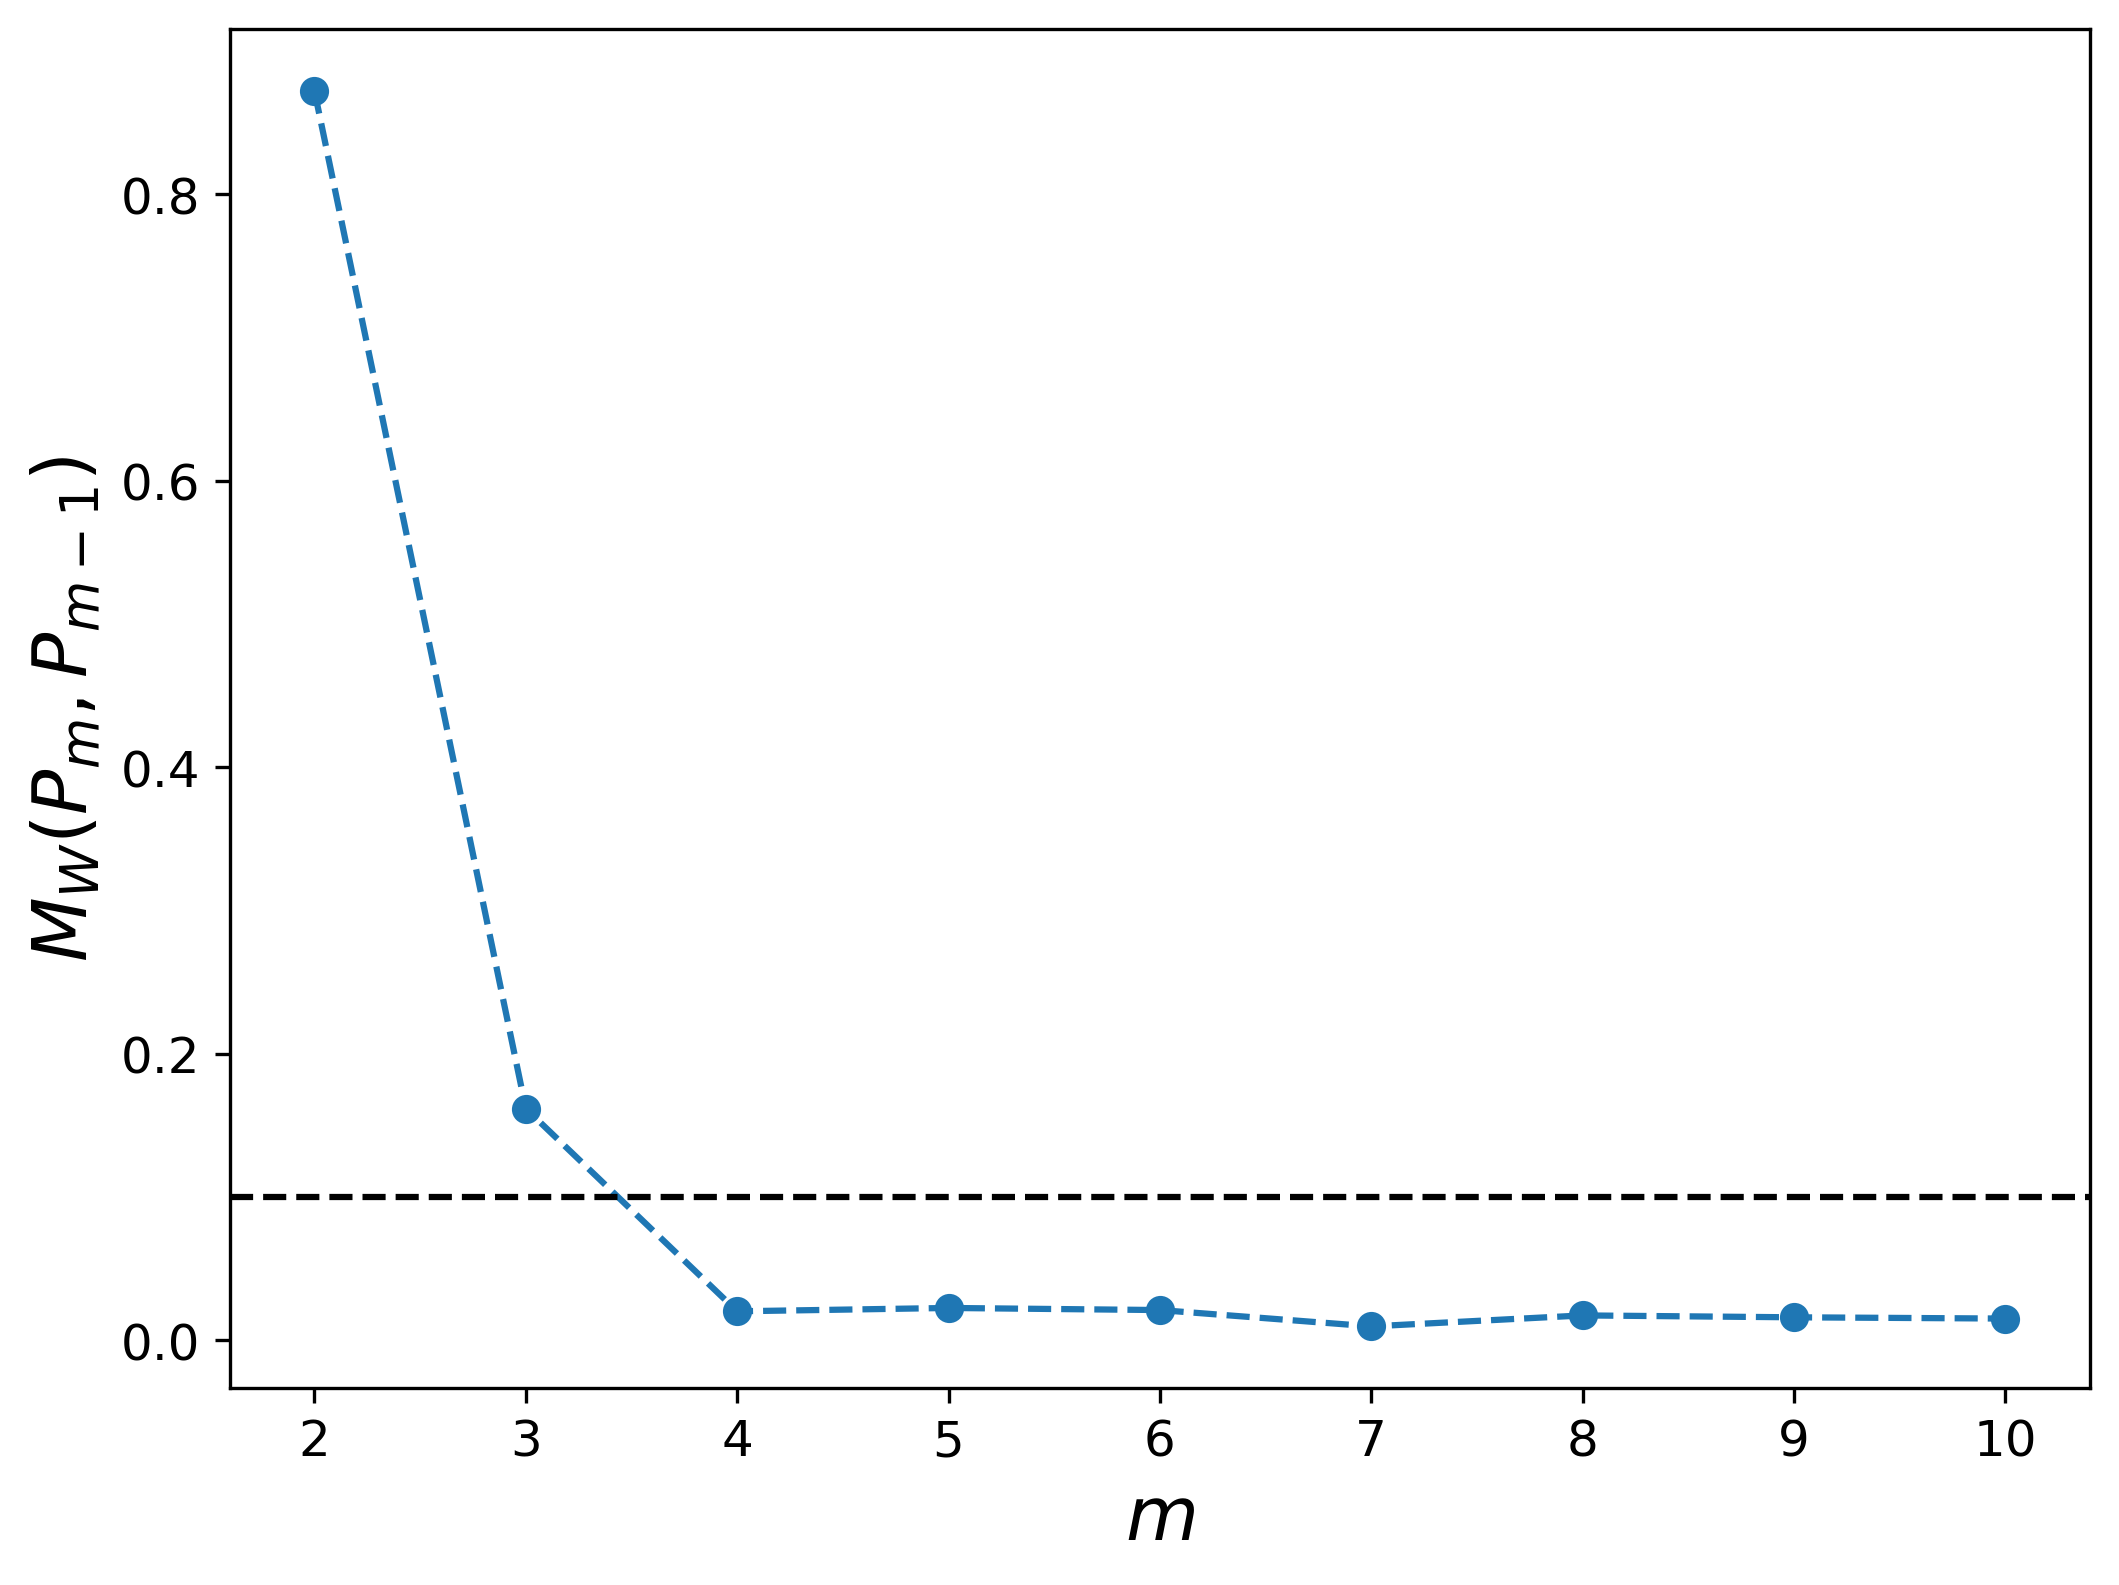

In [8]:
print(KS_vals)
plt.figure(figsize=(8,6), dpi=300)
plt.plot(dim_range[1:]+1, KS_vals, linestyle='--', marker='o')
plt.ylabel('$M_W(P_m, P_{m-1})$', fontsize=18)
plt.xlabel('$m$', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0.1, color='black', linestyle='--')
plt.savefig(output_dir + '/lorenz_WD.png')